In [4]:
import deslib
import numpy as np
import deslib
import sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from deslib.dcs import MLA, Rank, LCA, APosteriori, APriori, BaseDCS, OLA
from deslib.des import KNORAU, METADES, DESP, KNORAE
import logging
from hdtree import *
from typing import Optional, Dict, List, Union
from sklearn.metrics import accuracy_score
from diss_eval.settings import DATA_PATH, KEEL_PATH
import diss_eval.settings as paths
import pandas as pd
from os.path import join as pjoin
from sklearn.datasets import fetch_openml
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
import os
from sklearn import tree
import graphviz
import datetime
import time
from collections import namedtuple
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from gon import GON
from typing import List
from scipy.stats import pearsonr
from aix360.algorithms.rbm import BRCGExplainer, BooleanRuleCG
from aix360.algorithms.rbm import FeatureBinarizer
import wittgenstein as lw
from gon_viz import *
from sklearn.tree import plot_tree
from lib import NodeRecord, RunEval, PATH_PAPER, PATH_PAPER_FIGS, RipperAdapterRuleset, prep_onthology_dataset, BRCGWrapper
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
import lib
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
import sklearn
import aix360

In [99]:
sklearn.__version__

'0.22.2.post1'

In [102]:
aix360.__version__

'0.2.0'

In [100]:
lw.__version__

'0.1.6'

In [5]:
logging.getLogger().setLevel(logging.DEBUG)

In [6]:
hsmw_blue = "#2a6bb7"
hsmw_orange = "#E97817"
tuc_green = "#6a8a26"

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)
standard_cmap = 'pastell'
sns.set_style("whitegrid")

In [7]:
df_fico = pd.read_csv(pjoin('datasets', 'fico_dataset.csv'))

In [8]:
df_fico = df_fico.iloc[:, 2:]

In [9]:
df_fico = df_fico.drop_duplicates()

In [10]:
df_fico.head()

ExternalRiskEstimate  MSinceOldestTradeOpen  MSinceMostRecentTradeOpen  \
0                    55                    144                          4   
1                    61                     58                         15   
2                    67                     66                          5   
3                    66                    169                          1   
4                    81                    333                         27   

   AverageMInFile  NumSatisfactoryTrades  NumTrades60Ever2DerogPubRec  \
0              84                     20                            3   
1              41                      2                            4   
2              24                      9                            0   
3              73                     28                            1   
4             132                     12                            0   

   NumTrades90Ever2DerogPubRec  PercentTradesNeverDelq  MSinceMostRecentDelq  \
0                            0                      83                     2   
1                            4                     100                    -7   
2                            0                     100                    -7   
3                            1                      93                    76   
4                            0                     100                    -7   

   MaxDelq2PublicRecLast12M  ...  MSinceMostRecentInqexcl7days  NumInqLast6M  \
0                         3  ...                             0             0   
1                         0  ...                             0             0   
2                         7  ...                             0             4   
3                         6  ...                             0             5   
4                         7  ...                             0             1   

   NumInqLast6Mexcl7days  NetFractionRevolvingBurden  \
0                      0                          33   
1                      0                           0   
2                      4                          53   
3                      4                          72   
4                      1                          51   

   NetFractionInstallBurden  NumRevolvingTradesWBalance  \
0                        -8                           8   
1                        -8                           0   
2                        66                           4   
3                        83                           6   
4                        89                           3   

   NumInstallTradesWBalance  NumBank2NatlTradesWHighUtilization  \
0                         1                                   1   
1                        -8                                  -8   
2                         2                                   1   
3                         4                                   3   
4                         1                                   0   

   PercentTradesWBalance  target  
0                     69     Bad  
1                      0     Bad  
2                     86     Bad  
3                     91     Bad  
4                     80     Bad  

[5 rows x 24 columns]

In [11]:
df_fico['target'].value_counts()

Bad     5136
Good    4736
Name: target, dtype: int64

In [95]:
len(df_fico)

9872

In [12]:
y_fico_binarized_pos_bad = np.array([*map(lambda lbl: 1. if lbl == 'Bad' else 0., 
                                    df_fico.iloc[:, -1].values)], dtype=np.bool)

In [13]:
X_fico_bin = FeatureBinarizer(negations=True, numThresh=10).fit_transform(df_fico.iloc[:, :-1].astype(np.int))

In [14]:
X_train_fico, X_test_fico, y_train_fico, y_test_fico, X_train_fico_binarized, X_test_fico_binarized, y_train_fico_binarized_pos_bad, y_test_fico_binarized_pos_bad = \
                                                                                train_test_split(
                                                                                    df_fico.iloc[:, :-1].astype(np.int), 
                                                                                    df_fico.iloc[:, -1],
                                                                                    X_fico_bin,
                                                                                    y_fico_binarized_pos_bad,
                                                                                    test_size=0.33, 
                                                                                    random_state=42)

In [15]:
X_train_fico.head(1)

ExternalRiskEstimate  MSinceOldestTradeOpen  MSinceMostRecentTradeOpen  \
3255                    82                    207                          4   

      AverageMInFile  NumSatisfactoryTrades  NumTrades60Ever2DerogPubRec  \
3255              69                     18                            0   

      NumTrades90Ever2DerogPubRec  PercentTradesNeverDelq  \
3255                            0                     100   

      MSinceMostRecentDelq  MaxDelq2PublicRecLast12M  ...  \
3255                    -7                         7  ...   

      PercentInstallTrades  MSinceMostRecentInqexcl7days  NumInqLast6M  \
3255                    16                             4             2   

      NumInqLast6Mexcl7days  NetFractionRevolvingBurden  \
3255                      2                           0   

      NetFractionInstallBurden  NumRevolvingTradesWBalance  \
3255                        -8                           0   

      NumInstallTradesWBalance  NumBank2NatlTradesWHighUtilization  \
3255                         1                                   0   

      PercentTradesWBalance  
3255                     14  

[1 rows x 23 columns]

## RIPPER

In [13]:
ripper_fico_bad = lw.RIPPER(verbosity=0)

In [14]:
ripper_fico_good = lw.RIPPER(verbosity=0)

In [16]:
ripper_fico_bad.fit(X_train_fico.copy(), y_train_fico.copy(), 
                  pos_class='Bad', n_discretize_bins=10)

In [19]:
ripper_fico_good.fit(X_train_fico.copy(), y_train_fico.copy(), 
                  pos_class='Good', n_discretize_bins=10)

In [20]:
print("Bad Rules\n---------------------")
ripper_fico_bad.ruleset_.out_pretty()

Bad Rules
---------------------
[[ExternalRiskEstimate=-9-60^MSinceMostRecentInqexcl7days=-9-0^MaxDelqEver=6^NumTradesOpeninLast12M=-9-1^PercentTradesNeverDelq=-9-78] V
[MSinceMostRecentInqexcl7days=-9-0^ExternalRiskEstimate=-9-60] V
[MSinceMostRecentInqexcl7days=-9-0^ExternalRiskEstimate=60-64] V
[ExternalRiskEstimate=64-67] V
[ExternalRiskEstimate=-9-60^NetFractionRevolvingBurden=70-91] V
[ExternalRiskEstimate=-9-60] V
[ExternalRiskEstimate=67-71^MSinceMostRecentInqexcl7days=-9-0^AverageMInFile=-9-40^NumRevolvingTradesWBalance=-9-2^NumInstallTradesWBalance=-9-2] V
[ExternalRiskEstimate=67-71^MSinceMostRecentInqexcl7days=-9-0^NetFractionRevolvingBurden=70-91] V
[ExternalRiskEstimate=67-71^MSinceMostRecentInqexcl7days=-9-0] V
[ExternalRiskEstimate=60-64^MSinceMostRecentDelq=-9-0] V
[ExternalRiskEstimate=71-75^MSinceMostRecentInqexcl7days=-9-0^NetFractionInstallBurden=90-99] V
[ExternalRiskEstimate=71-75^MSinceMostRecentInqexcl7days=-9-0^NumTotalTrades=21-25] V
[AverageMInFile=-9-40^MSi

In [22]:
print("Good Rules\n---------------------")
ripper_fico_good.ruleset_.out_pretty()

Good Rules
---------------------
[[MaxDelq2PublicRecLast12M=7^ExternalRiskEstimate=83-88] V
[ExternalRiskEstimate=79-83] V
[ExternalRiskEstimate=75-79^MSinceMostRecentInqexcl7days=1-4^MaxDelq2PublicRecLast12M=6] V
[ExternalRiskEstimate=75-79] V
[ExternalRiskEstimate=71-75^NumSatisfactoryTrades=37-78^PercentTradesWBalance=38-48] V
[ExternalRiskEstimate=71-75^PercentTradesNeverDelq=96-99] V
[ExternalRiskEstimate=71-75^NumSatisfactoryTrades=26-30] V
[PercentTradesWBalance=-9-38^ExternalRiskEstimate=88-94^NumTotalTrades=29-34] V
[NumBank2NatlTradesWHighUtilization=-9-1^ExternalRiskEstimate=88-94^NumTotalTrades=17-21] V
[ExternalRiskEstimate=71-75^NetFractionInstallBurden=43-61] V
[ExternalRiskEstimate=71-75^PercentInstallTrades=15-21] V
[ExternalRiskEstimate=71-75^PercentTradesWBalance=38-48] V
[ExternalRiskEstimate=88-94] V
[ExternalRiskEstimate=67-71^AverageMInFile=95-108] V
[ExternalRiskEstimate=67-71^MSinceMostRecentInqexcl7days=11-24] V
[ExternalRiskEstimate=71-75^NumSatisfactoryTrade

In [23]:
print("Bad Score\n---------------------")
ripper_fico_bad.score(X_train_fico, y_train_fico), ripper_fico_bad.score(X_test_fico, y_test_fico)

Bad Score
---------------------


(0.7358633202298155, 0.7031921424186618)

In [24]:
print("Good Score\n---------------------")
ripper_fico_good.score(X_train_fico, y_train_fico), ripper_fico_good.score(X_test_fico, y_test_fico)

Good Score
---------------------


(0.7394919866948896, 0.7148557397176182)

In [25]:
print("Coverage Bad")
ripper_adapter_bad = RipperAdapterRuleset(ripper=ripper_fico_bad)
n_covered_test = len(ripper_adapter_bad.get_covered_samples(X_test_fico))
n_covered_train = len(ripper_adapter_bad.get_covered_samples(X_train_fico))
n_covered_train/len(X_train_fico), \
n_covered_test/len(X_test_fico)

Coverage Bad


(0.5043846386452978, 0.49662369551872315)

In [26]:
print("Coverage Good")
ripper_adapter_good = RipperAdapterRuleset(ripper=ripper_fico_good)
n_covered_test = len(ripper_adapter_good.get_covered_samples(X_test_fico))
n_covered_train = len(ripper_adapter_good.get_covered_samples(X_train_fico))
n_covered_train/len(X_train_fico), \
n_covered_test/len(X_test_fico)

Coverage Good


(0.47051708497127304, 0.47391037446286066)

In [27]:
print("Avg Rule condition Bad")
ripper_adapter_bad.calc_avg_rule_length(), ripper_adapter_bad.count_rules()

Avg Rule condition Bad


(2.5, 18)

In [28]:
print("Avg Rule condition good")
ripper_adapter_good.calc_avg_rule_length(), ripper_adapter_good.count_rules()

Avg Rule condition good


(2.4, 25)

## BRCG

In [35]:
brcg_fico_pos_bad = BooleanRuleCG(silent=True)
brcg_fico_explainer_pos_bad = BRCGExplainer(brcg_fico_pos_bad)
brcg_fico_explainer_pos_bad.fit(X_train_fico_binarized, y_train_fico_binarized_pos_bad)

In [32]:
brcg_fico_pos_good = BooleanRuleCG(silent=True)
brcg_fico_explainer_pos_good = BRCGExplainer(brcg_fico_pos_good)
brcg_fico_explainer_pos_good.fit(X_train_fico_binarized, ~y_train_fico_binarized_pos_bad)

In [41]:
wrapper_brcg_pos_bad = BRCGWrapper(brcg=brcg_fico_explainer_pos_bad)
wrapper_brcg_pos_good = BRCGWrapper(brcg=brcg_fico_explainer_pos_good)

In [42]:
print("BRCG Pos Bad\n-----------------------")
isCNF = 'Predict Y=0 if ANY of the following rules are satisfied, otherwise Y=1:'
notCNF = 'Predict Y=1 if ANY of the following rules are satisfied, otherwise Y=0:'
print(isCNF if brcg_fico_explainer_pos_bad.explain()['isCNF'] else notCNF)
print()
for rule in brcg_fico_explainer_pos_bad.explain()['rules']:
    print(f'  - {rule}')

BRCG Pos Bad
-----------------------
Predict Y=1 if ANY of the following rules are satisfied, otherwise Y=0:

  - ExternalRiskEstimate <= 73.00


In [45]:
print("BRCG Pos Good\n-----------------------")
isCNF = 'Predict Y=0 if ANY of the following rules are satisfied, otherwise Y=1:'
notCNF = 'Predict Y=1 if ANY of the following rules are satisfied, otherwise Y=0:'
print(isCNF if brcg_fico_explainer_pos_good.explain()['isCNF'] else notCNF)
print()
for rule in brcg_fico_explainer_pos_good.explain()['rules']:
    print(f'  - {rule}')

BRCG Pos Good
-----------------------
Predict Y=1 if ANY of the following rules are satisfied, otherwise Y=0:

  - ExternalRiskEstimate > 73.00 AND MSinceMostRecentInqexcl7days <= 0.00
  - ExternalRiskEstimate > 65.00 AND AverageMInFile > 50.00 AND PercentTradesNeverDelq > 75.00 AND MSinceMostRecentInqexcl7days > 0.00


In [47]:
print("Score BRCG Pos Bad\n-----------------------")
accuracy_score(brcg_fico_explainer_pos_bad.predict(X_train_fico_binarized), 
               y_train_fico_binarized_pos_bad), accuracy_score(brcg_fico_explainer_pos_bad.predict(X_test_fico_binarized), 
               y_test_fico_binarized_pos_bad)

Score BRCG Pos Bad
-----------------------


(0.7112186271545207, 0.7038060159607121)

In [53]:
print("Score BRCG Pos Good\n-----------------------")
accuracy_score(brcg_fico_explainer_pos_good.predict(X_train_fico_binarized), 
               ~y_train_fico_binarized_pos_bad), accuracy_score(brcg_fico_explainer_pos_good.predict(X_test_fico_binarized), 
               ~y_test_fico_binarized_pos_bad)

Score BRCG Pos Good
-----------------------


(0.7234653764741458, 0.7053406998158379)

In [56]:
print("# Rule bad, avg rule length")
wrapper_brcg_pos_bad.count_rules(), wrapper_brcg_pos_bad.calc_avg_rule_length()

# Rule bad, avg rule length


(1, 1.0)

In [55]:
print("# Rule good, avg rule length")
wrapper_brcg_pos_good.count_rules(), wrapper_brcg_pos_good.calc_avg_rule_length()

# Rule good, avg rule length


(2, 3.0)

In [58]:
print("Coverage bad")
len(wrapper_brcg_pos_bad.get_covered_samples(X_train_fico_binarized))/len(X_train_fico_binarized), \
len(wrapper_brcg_pos_bad.get_covered_samples(X_test_fico_binarized))/len(X_test_fico_binarized)

Coverage bad


(0.565013607499244, 0.5629220380601596)

In [59]:
print("Coverage good")
len(wrapper_brcg_pos_good.get_covered_samples(X_train_fico_binarized))/len(X_train_fico_binarized), \
len(wrapper_brcg_pos_good.get_covered_samples(X_test_fico_binarized))/len(X_test_fico_binarized)

Coverage good


(0.4850317508315694, 0.4821976672805402)

## GoN

In [16]:
# GON
trees_fico = [HDTreeClassifier(allowed_splits=[# SmallerThanSplit,
                            FixedValueSplit.build(),
                            TenQuantileRangeSplit.build_with_restrictions(max_level=1),
                            TenQuantileSplit.build_with_restrictions(max_level=0),
                            TwentyQuantileRangeSplit.build_with_restrictions(min_level=2),
                            TwentyQuantileSplit.build_with_restrictions(min_level=1),
                            ],
                        min_samples_at_leaf=20,
                        information_measure=EntropyMeasure(),
                        attribute_names=df_fico.columns[:-1],
                        max_levels=1, 
                        verbose=False) for i in range(4)]

In [17]:
gon_fico = GON(pool_classifiers=trees_fico,
                  DSEL_perc=0.,
                  step_size=2,
                  iterations=20,
                  max_jobs=1,
                  val_perc=0.0,
                  maximum_selected_features=8,
                  random_state=42)

In [18]:
gon_fico.fit(X_train_fico.values, 
               y_train_fico.values, 
               X_expert=X_train_fico.values)

In [19]:
gon_fico.score(X_train_fico.values, y_train_fico.values, X_train_fico.values), \
gon_fico.score(X_test_fico.values, y_test_fico.values, X_test_fico.values)

(0.7190807378288478, 0.712707182320442)

In [77]:
gon_fico.pool_classifiers_[2].set_max_level(2)

In [78]:
gon_fico.refit_nerds()

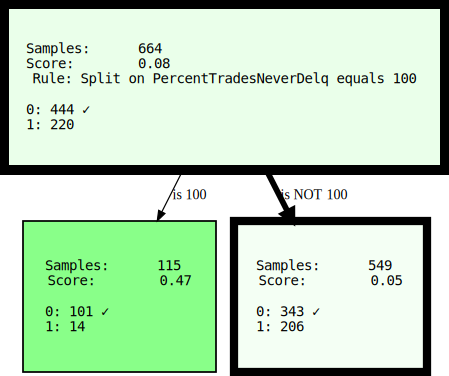

In [79]:
gon_fico.pool_classifiers_[3].generate_dot_graph()

In [80]:
print("Gon Score Final")
gon_fico.score(X_train_fico.values, y_train_fico.values, X_train_fico.values), \
gon_fico.score(X_test_fico.values, y_test_fico.values, X_test_fico.values)

Gon Score Final


(0.719685515573027, 0.7160834868017188)

In [84]:
rule_gon_fico = GonRuleLearner.from_gon_instance(gon_fico, 
                                                  max_length_assignment=2, 
                                                  min_precision=0.5,
                                                  min_coverage=0.01)

In [85]:
pd.set_option('display.max_colwidth', 100)
rule_gon_fico.explain()

Rule 1  \
0                              ExternalRiskEstimate ≥ 76.0   
1                                    AverageMInFile ≥ 54.0   
2                              ExternalRiskEstimate < 69.0   
3                                    AverageMInFile ≥ 54.0   
4  ExternalRiskEstimate is INSIDE range [68.00, ... 70.00[   
5                                    AverageMInFile < 54.0   

                                                    Rule 2  \
0                                                            
1                       MSinceMostRecentInqexcl7days ≥ 1.0   
2              ExternalRiskEstimate doesn't match value 68   
3                       MSinceMostRecentInqexcl7days < 1.0   
4                                                            
5  ExternalRiskEstimate is INSIDE range [70.00, ... 76.00[   

                                                    Rule 3  \
0                                                            
1  ExternalRiskEstimate is INSIDE range [70.00, ... 76.00[   
2                                                            
3  ExternalRiskEstimate is INSIDE range [70.00, ... 76.00[   
4                                                            
5                                                            

   Coverage in Percent  Precision in Percent Nerd Prediction  
0                37.19                 73.86   #2       Good  
1                 4.91                 68.00   #3       Good  
2                35.85                 79.08   #1        Bad  
3                10.58                 52.29   #3        Bad  
4                 7.09                 62.26   #4        Bad  
5                 4.37                 65.40   #3        Bad

In [86]:
print("Rule Predictor Scores")
rule_gon_fico.score(X_train_fico.values, y_train_fico.values), \
rule_gon_fico.score(X_test_fico.values, y_test_fico.values)

Rule Predictor Scores


(0.719685515573027, 0.7173112338858195)

In [89]:
df_fico.loc[X_train_fico.query("ExternalRiskEstimate < 68").index]['target'].value_counts()

Bad     3303
Good    3050
Name: target, dtype: int64

In [91]:
print("Rule Predictor Coverage")
rule_gon_fico.calculate_rule_coverage(X_train_fico),\
rule_gon_fico.calculate_rule_coverage(X_test_fico)

Rule Predictor Coverage


(1.0, 1.0)

In [92]:
print("Rule Predictor GoN Agreement")
rule_gon_fico.calculate_agreement_with_gon(X=X_train_fico, X_expert=X_train_fico, gon=gon_fico), \
rule_gon_fico.calculate_agreement_with_gon(X=X_test_fico, X_expert=X_test_fico, gon=gon_fico)

Rule Predictor GoN Agreement


(0.9259147263380707, 0.9238796807857581)

In [93]:
print("avg length")
rule_gon_fico.calc_avg_rule_length(), \
rule_gon_fico.count_rules()

avg length


(2.0, 6)

## Decison Tree

In [416]:
tree_fico = DecisionTreeClassifier(min_samples_leaf=1, max_depth=None, ccp_alpha=0.001)

In [417]:
tree_fico.fit(X_train_fico, y_train_fico)

DecisionTreeClassifier(ccp_alpha=0.001, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [418]:
print("Performance Decision Tree")
tree_fico.score(X_train_fico, y_train_fico), \
tree_fico.score(X_test_fico, y_test_fico)

Performance Decision Tree


(0.7405503477472029, 0.7124002455494168)

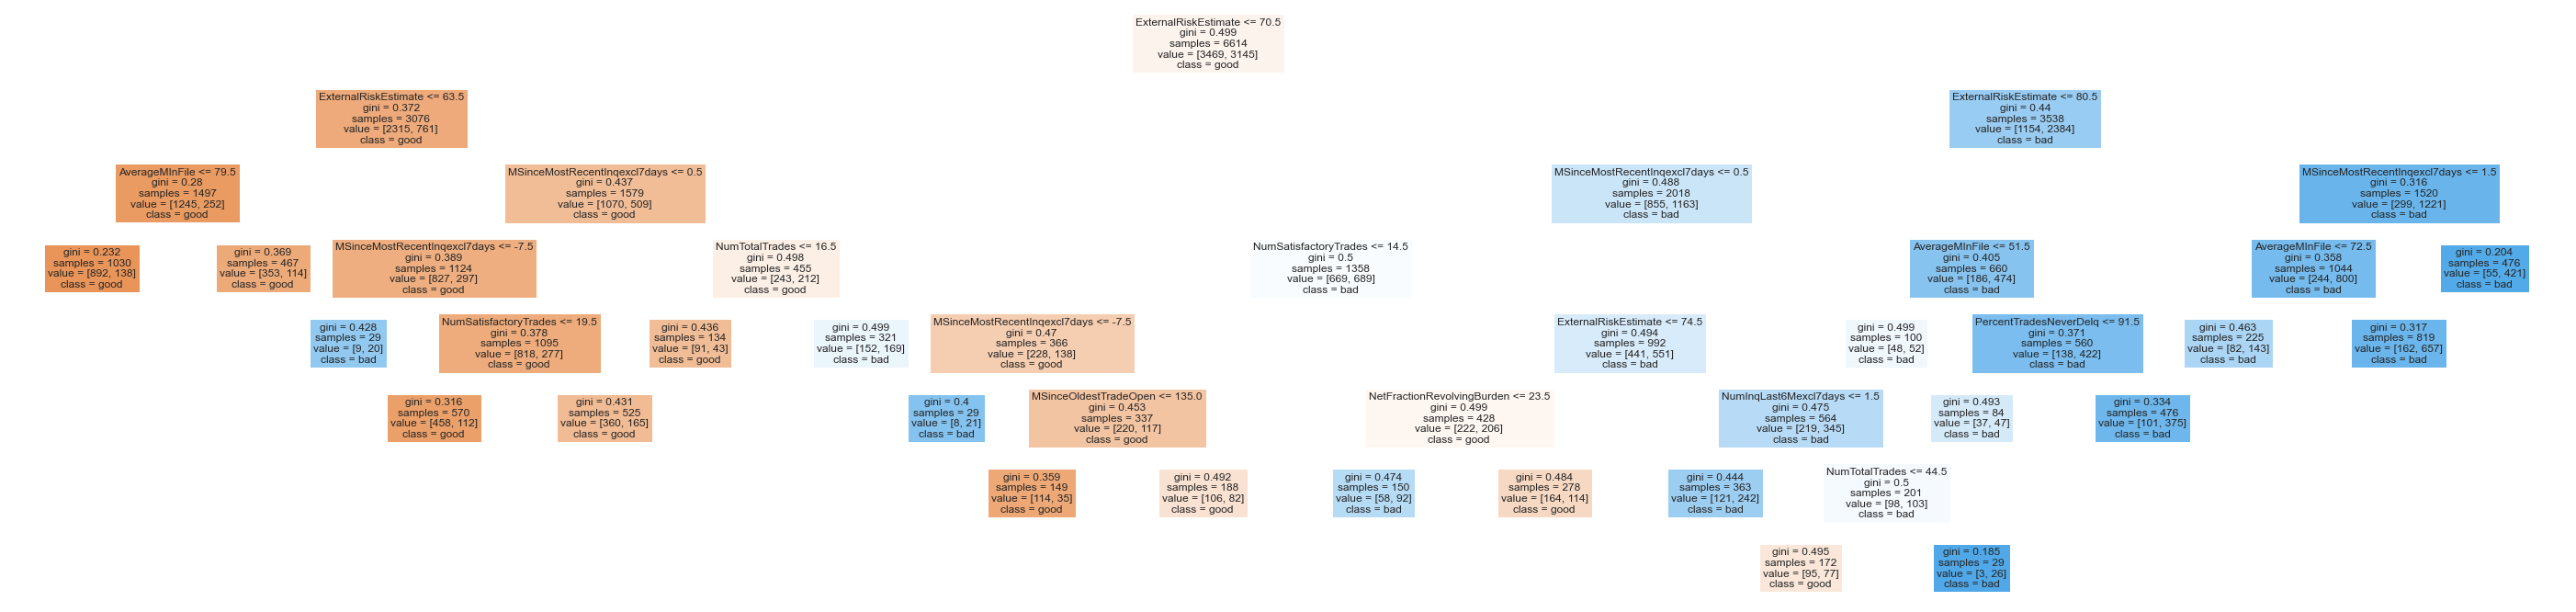

In [446]:
fig, ax = plt.subplots(1,1, figsize=(50,12))
_ = plot_tree(tree_fico, feature_names=X_train_fico.columns, 
              class_names=['good', 'bad'], 
              filled=True, ax=ax, fontsize=12, )

In [466]:
leaf_depths = lib.get_leaf_depths_sklearn_tree(tree_fico)

In [467]:
len(leaf_depths), np.mean(leaf_depths)

(21, 4.857142857142857)

## MLP

In [504]:
mlp_grid = {
    'hidden_layer_sizes': [(100,), (2,2), (4,4), (8,8), (16,16), (32, 32), (64, 64), (128, 128)],
    'random_state': [42],
}

In [505]:
mlp_fico = MLPClassifier()

In [506]:
grid_mlp_fico = GridSearchCV(mlp_fico, param_grid=mlp_grid)

In [507]:
grid_mlp_fico.fit(X_train_fico, y_train_fico)

C:\Users\Richard\Anaconda3\envs\gonviz\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Richard\Anaconda3\envs\gonviz\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Richard\Anaconda3\envs\gonviz\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Richard\Anaconda3\envs\gonviz\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_gr

In [508]:
grid_mlp_fico.best_estimator_

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(8, 8), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [509]:
grid_mlp_fico.score(X_train_fico, y_train_fico), \
grid_mlp_fico.score(X_test_fico, y_test_fico)

(0.7157544602358633, 0.7016574585635359)

## SVC

In [510]:
svc_fico = SVC()

In [511]:
svc_fico.fit(X_train_fico, y_train_fico)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [512]:
svc_fico.score(X_train_fico, y_train_fico), \
svc_fico.score(X_test_fico, y_test_fico)

(0.7320834593286967, 0.7240638428483732)